In [1]:
import sys
## import all the packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
## read NHANES dataset
df = pd.read_csv('/Users/zhiyi/Desktop/for Yupei/CRCLM_ml.csv')

In [3]:
## find all the distinct values of DIQ170
df.y.value_counts()

0    23100
1     5528
Name: y, dtype: int64

In [4]:
## data preparation
# exclude null values and NA
df = df[df.y.notnull()]
# check DIQ170
df.y.describe()

count    28628.000000
mean         0.193098
std          0.394736
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: y, dtype: float64

In [5]:
# exclude non-numeric values
d = df.select_dtypes(['number'])

# exclude columns that have over 50% NaN
d = d.dropna(thresh = 0.5*len(d), axis =1)

print(len(d.columns), 'columns are left')

21 columns are left


In [6]:
# transform the coding of target variable
d['y']= d.apply(lambda x: 1 if x.y == 1 else 0, axis='columns')
d.y.value_counts() 

0    23100
1     5528
Name: y, dtype: int64

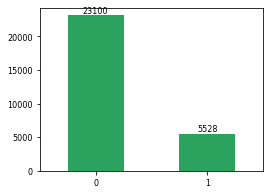

In [7]:
## plot the distribution of values of response variable
vals = d.y.value_counts()

plt.figure(figsize=(4,3))
plt.rc('font', size=8)

ax = vals.plot.bar(rot=0, color='#2ca25f')
for i in range(len(vals)):
    ax.annotate(vals[i], xy=[vals.index[i], vals[i]], ha='center', va='bottom')

In [8]:
# replace NA with most frequent values
from sklearn.impute import SimpleImputer
sim_imp = SimpleImputer(strategy='most_frequent')

## avoid COD
d = pd.DataFrame(sim_imp.fit_transform(d), columns=d.columns)
d = d.loc[d['COD'] != 2]
d = d.drop(columns='COD')

## show the complete dataset
d 

,y,GENDER,RACE,AGE,SIZE,MARRY,INCOME,SITE,GRADE,KIND,T,N,SURGERY,RX,RADIATE,CHEM,CEA,BONE,BRAIN,LUNG
0,1,2,2,3,3,1,3,1,9,1,3,3,0,0,0,0,1,0,0,1
1,0,2,1,3,1,2,3,1,2,1,2,1,1,1,0,1,2,0,0,0
2,0,1,1,3,1,3,3,2,2,1,2,2,1,0,0,0,0,0,0,0
3,0,2,1,3,3,2,3,2,2,1,2,1,0,0,0,1,1,0,0,0
4,0,1,3,3,1,3,3,1,9,1,2,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28621,0,2,1,3,2,2,2,2,2,2,2,2,1,0,0,1,2,0,0,0
28622,1,2,1,3,3,3,2,1,9,1,3,1,0,0,0,0,2,0,0,0
28623,1,2,2,3,1,3,1,2,2,2,2,1,1,0,0,1,2,0,0,0
28624,0,1,1,2,1,1,1,1,9,1,3,3,0,0,0,1,1,0,0,1


In [9]:
## separate predictors and responses
X = d.loc[:, d.columns != 'y']
Y = d.y
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (26739, 19)
Y shape: (26739,)


In [10]:
## split the data into training dataset and testing dataset (8:2)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=12)

In [11]:
## Feature selection: XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = XGBClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## confusion matrix
def confusion(Y_test, Y_pred):
    conf = pd.DataFrame(confusion_matrix(Y_test, Y_pred), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf

confusion(Y_test, Y_pred) 

Accuracy: 82.91%
Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        4081         266
True[1]         648         353


,Predict[0],Predict[1]
True[0],4081,266
True[1],648,353


In [12]:
## Oversampling with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
X_test_smote, Y_test_smote = smote.fit_resample(X_test, Y_test)

X_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
X_test_smote = pd.DataFrame(X_test_smote, columns=X.columns)

## show the dataset after SMOTE
print(Y_train_smote.value_counts())
print(Y_test_smote.value_counts())

1    17400
0    17400
Name: y, dtype: int64
0    4347
1    4347
Name: y, dtype: int64


In [13]:
# The classification result after SMOTE
model = XGBClassifier()
model.fit(X_train_smote, Y_train_smote)
Y_pred_smote = model.predict(X_test_smote)

accuracy = accuracy_score(Y_test_smote, Y_pred_smote)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
conf = pd.DataFrame(confusion_matrix(Y_test_smote, Y_pred_smote), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
conf

Accuracy: 76.16%


,Predict[0],Predict[1]
True[0],3426,921
True[1],1152,3195


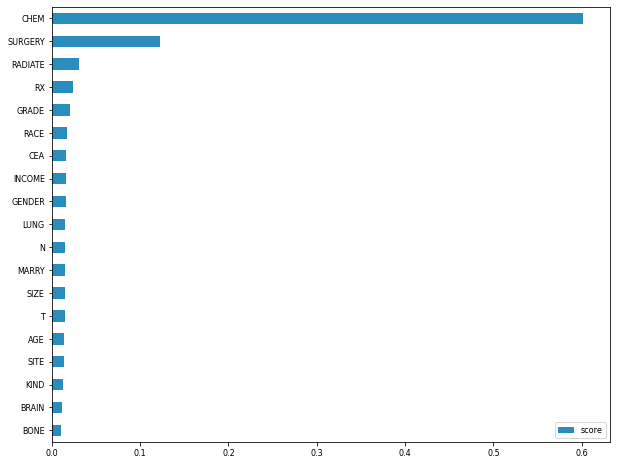

In [14]:
from xgboost import XGBClassifier
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X_train_smote, Y_train_smote)

# Features selected by XGBoost
keys = list(model.get_booster().feature_names)
values = list(model.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

# Top xxx features
xgbfs_ = data[:]

# Plot feature score
xgbfs_.sort_values(by='score').plot(kind='barh', figsize=(10, 8), color='#2b8cbe')
plt.rc('font', size=8)

In [15]:
xgbfs = xgbfs_.reset_index()
xgbfs.columns=['variable', 'score']

xgbfs['variable'] = xgbfs['variable'].apply(lambda x: x.upper())

In [16]:
## all variables list
var_list = xgbfs.variable.tolist()
var_list.append('y')
print(var_list)
df_final = d.filter(var_list)
df_final

['CHEM', 'SURGERY', 'RADIATE', 'RX', 'GRADE', 'RACE', 'CEA', 'INCOME', 'GENDER', 'LUNG', 'N', 'MARRY', 'SIZE', 'T', 'AGE', 'SITE', 'KIND', 'BRAIN', 'BONE', 'y']


,CHEM,SURGERY,RADIATE,RX,GRADE,RACE,CEA,INCOME,GENDER,LUNG,N,MARRY,SIZE,T,AGE,SITE,KIND,BRAIN,BONE,y
0,0,0,0,0,9,2,1,3,2,1,3,1,3,3,3,1,1,0,0,1
1,1,1,0,1,2,1,2,3,2,0,1,2,1,2,3,1,1,0,0,0
2,0,1,0,0,2,1,0,3,1,0,2,3,1,2,3,2,1,0,0,0
3,1,0,0,0,2,1,1,3,2,0,1,2,3,2,3,2,1,0,0,0
4,0,0,0,0,9,3,1,3,1,1,1,3,1,2,3,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28621,1,1,0,0,2,1,2,2,2,0,2,2,2,2,3,2,2,0,0,0
28622,0,0,0,0,9,1,2,2,2,0,1,3,3,3,3,1,1,0,0,1
28623,1,1,0,0,2,2,2,1,2,0,1,3,1,2,3,2,2,0,0,1
28624,1,0,0,0,9,1,1,1,1,1,3,1,1,3,2,1,1,0,0,0


<AxesSubplot:>

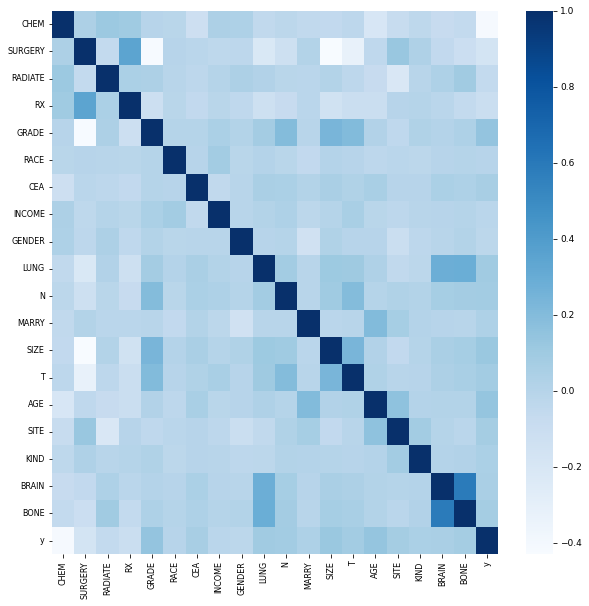

In [17]:
## draw correlation heatmap
ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=9)

corr = df_final.corr()

sns.heatmap(corr, cmap="Blues")

In [18]:
X_scale = df_final.loc[:, df_final.columns != 'y']
Y = df_final.y

In [19]:
## min-max scaling
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
X = pd.DataFrame(minmax.fit_transform(X_scale), columns=X_scale.columns)
X

,CHEM,SURGERY,RADIATE,RX,GRADE,RACE,CEA,INCOME,GENDER,LUNG,N,MARRY,SIZE,T,AGE,SITE,KIND,BRAIN,BONE
0,0.0,0.0,0.0,0.0,1.000,0.5,0.5,1.0,1.0,0.5,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,1.0,0.125,0.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.5,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.125,0.0,0.0,1.0,0.0,0.0,0.5,1.0,0.0,0.5,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.125,0.0,0.5,1.0,1.0,0.0,0.0,0.5,1.0,0.5,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.000,1.0,0.5,1.0,0.0,0.5,0.0,1.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26734,1.0,1.0,0.0,0.0,0.125,0.0,1.0,0.5,1.0,0.0,0.5,0.5,0.5,0.5,1.0,1.0,1.0,0.0,0.0
26735,0.0,0.0,0.0,0.0,1.000,0.0,1.0,0.5,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
26736,1.0,1.0,0.0,0.0,0.125,0.5,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.5,1.0,1.0,1.0,0.0,0.0
26737,1.0,0.0,0.0,0.0,1.000,0.0,0.5,0.0,0.0,0.5,1.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0


In [20]:
## Create an empty list containing the accuracy scores of the models
mscore=[]

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=11)

X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
X_test_smote, Y_test_smote = smote.fit_resample(X_test, Y_test)

X_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
X_test_smote = pd.DataFrame(X_test_smote, columns=X.columns)

In [22]:
## Logistic Regression
from sklearn.linear_model import LogisticRegression
import time

clf = LogisticRegression(max_iter=100, solver='lbfgs', class_weight='balanced', random_state=11)

## time of running
tic = time.time()
clf.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

clf_prediction_proba = clf.predict_proba(X_test)[:, 1]

## make predictions
Y_pred = clf.predict(X_test)
print('Accuracy Score:', clf.score(X_test, Y_test))
print('Prediction:', Y_pred)

## append the score to the list
mscore.append(['Logistic Regression', clf.score(X_test, Y_test)])

print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

Time: 167.11783409118652ms
Accuracy Score: 0.7608077786088258
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      5431
           1       0.42      0.72      0.53      1254

    accuracy                           0.76      6685
   macro avg       0.67      0.74      0.68      6685
weighted avg       0.83      0.76      0.78      6685

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        4187        1244
True[1]         355         899


,Predict[0],Predict[1]
True[0],4187,1244
True[1],355,899


In [23]:
## random forest model
from sklearn.ensemble import RandomForestClassifier
import time

rnd_clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5, 
                                 min_samples_split = 2, min_samples_leaf = 1, random_state=11)

## time of running
tic = time.time()
rnd_clf.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

rf_prediction_proba = rnd_clf.predict_proba(X_test)[:, 1]

## make predictions
Y_pred = rnd_clf.predict(X_test)
print('Accuracy Score:', rnd_clf.score(X_test, Y_test))
print('Prediction:', Y_pred)

## append the score to the list
mscore.append(['Random Forest', rnd_clf.score(X_test, Y_test)])

print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

## print importance tree random forest
print(pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

Time: 2836.888074874878ms
Accuracy Score: 0.7766641735228123
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      5431
           1       0.44      0.66      0.53      1254

    accuracy                           0.78      6685
   macro avg       0.67      0.73      0.69      6685
weighted avg       0.82      0.78      0.79      6685

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        4364        1067
True[1]         426         828
   Variable  Importance
14      AGE    0.601713
11    MARRY    0.122724
13        T    0.030274
12     SIZE    0.024202
7    INCOME    0.020540
1   SURGERY    0.017031
15     SITE    0.016062
5      RACE    0.015999
0      CHEM    0.015533
18     BONE    0.015480
10        N    0.015143
4     GRADE    0.014923
3        RX    0.014401
9      LUNG    0.014367
2   RADIATE    0.013860
6       CEA    0.013256
8    GENDER    0.012104
17    BRAIN    0.011578
16     KIND 

In [24]:
## gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
import time

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, random_state=11)

## time of running
tic = time.time()
gbc.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

gbc_prediction_proba = gbc.predict_proba(X_test)[:, 1]

## make predictions
Y_pred = gbc.predict(X_test)
print('Accuracy Score:', gbc.score(X_test, Y_test))
print('Prediction:', Y_pred)

## append the score to the list
mscore.append(['Gradient Boosting', gbc.score(X_test, Y_test)])

print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

Time: 409.69395637512207ms
Accuracy Score: 0.8080777860882573
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      5431
           1       0.49      0.59      0.54      1254

    accuracy                           0.81      6685
   macro avg       0.70      0.73      0.71      6685
weighted avg       0.82      0.81      0.81      6685

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        4656         775
True[1]         508         746


,Predict[0],Predict[1]
True[0],4656,775
True[1],508,746


In [25]:
## Adaboost Classifier
from sklearn.ensemble import AdaBoostClassifier
import time

ada = AdaBoostClassifier(learning_rate=0.01, n_estimators=30, random_state=11)

tic = time.time()
ada.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

ada_prediction_proba = ada.predict_proba(X_test)[:, 1]

Y_pred = ada.predict(X_test)
print('Accuracy Score:', ada.score(X_test, Y_test))
print('Prediction:', Y_pred)

mscore.append(['Adaptive Boosting', ada.score(X_test, Y_test)])

# from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

Time: 773.3981609344482ms
Accuracy Score: 0.8080777860882573
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      5431
           1       0.49      0.60      0.54      1254

    accuracy                           0.81      6685
   macro avg       0.70      0.73      0.71      6685
weighted avg       0.82      0.81      0.81      6685

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        4654         777
True[1]         506         748


,Predict[0],Predict[1]
True[0],4654,777
True[1],506,748


In [26]:
## Extreme Gradient Boosting
from xgboost import XGBClassifier
import time

xgbc = XGBClassifier(eta=0.01, max_depth=3, random_state=11)

tic = time.time()
xgbc.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

xgb_prediction_proba = xgbc.predict_proba(X_test)[:, 1]

Y_pred = xgbc.predict(X_test)
print('Accuracy Score:', xgbc.score(X_test, Y_test))
print('Prediction:', Y_pred)

mscore.append(['XGBoost', xgbc.score(X_test, Y_test)])

# from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

Time: 2665.764093399048ms
Accuracy Score: 0.8080777860882573
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      5431
           1       0.49      0.59      0.54      1254

    accuracy                           0.81      6685
   macro avg       0.70      0.73      0.71      6685
weighted avg       0.82      0.81      0.81      6685

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        4656         775
True[1]         508         746


,Predict[0],Predict[1]
True[0],4656,775
True[1],508,746


In [27]:
## Support Vector Machine
from sklearn.svm import SVC
import time

svm_clf = SVC(kernel='sigmoid', gamma='auto', random_state=11, probability=True)

## time of running
tic = time.time()
svm_clf.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

svm_prediction_proba = svm_clf.predict_proba(X_test)[:, 1]

Y_pred = svm_clf.predict(X_test)
print('Accuracy Score:', svm_clf.score(X_test, Y_test))
print('Prediction:', Y_pred)

mscore.append(['SVM', svm_clf.score(X_test, Y_test)])

# from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))
confusion(Y_test, Y_pred)

Time: 653257.9319477081ms
Accuracy Score: 0.6846671652954376
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      5431
           1       0.34      0.70      0.45      1254

    accuracy                           0.68      6685
   macro avg       0.62      0.69      0.62      6685
weighted avg       0.80      0.68      0.72      6685

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        3702        1729
True[1]         379         875


,Predict[0],Predict[1]
True[0],3702,1729
True[1],379,875


In [28]:
## Bagging K-Nearest Neighbors
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

bagging = BaggingClassifier(base_estimator= KNeighborsClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False, random_state=11)

## time of running
tic = time.time()
bagging.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time: " + str(1000*(toc-tic)) + "ms")

kn_prediction_proba = bagging.predict_proba(X_test)[:, 1]

## make predictions
Y_pred = bagging.predict(X_test)
print('Accuracy Score:', bagging.score(X_test, Y_test))
print('Prediction:', Y_pred)

bg_score = bagging.score(X_test, Y_test)
bagging.score(X_test, Y_test)

## append the score to the list
mscore.append(['Bagging_KNeighbors', bagging.score(X_test, Y_test)])

Time: 294.9938774108887ms
Accuracy Score: 0.8179506357516829
Prediction: [0 0 0 ... 0 0 0]


In [29]:
## Bagging Decision Tree
from sklearn.tree import DecisionTreeClassifier
import time

bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(), max_samples = 0.5, max_features = 0.5, 
                            bootstrap = False, bootstrap_features = False, random_state=11)

## time of running
tic = time.time()
bagging.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time:" + str(1000*(toc-tic)) + "ms")

bdt_prediction_proba = bagging.predict_proba(X_test)[:, 1]

## make predictions
Y_pred = bagging.predict(X_test)
print('Accuracy Score:', bagging.score(X_test, Y_test))
print('Prediction:', Y_pred)

bg_dt_score = bagging.score(X_test, Y_test)
bagging.score(X_test, Y_test)

## append the score to the list
mscore.append(['Bagging_Decision Tree based', bagging.score(X_test, Y_test)])

Time:344.72203254699707ms
Accuracy Score: 0.8197456993268512
Prediction: [0 0 0 ... 0 0 0]


In [30]:
## MLP
from sklearn.neural_network import MLPClassifier
import time

mlp = MLPClassifier(hidden_layer_sizes=(100,100), solver='adam', shuffle=False, tol = 0.0001, random_state=11)

## time of running
tic = time.time()
mlp.fit(X_train_smote, Y_train_smote)
toc = time.time()
print("Time:" + str(1000*(toc-tic)) + "ms")

mlp_prediction_proba = mlp.predict_proba(X_test)[:, 1]

## make predictions
Y_pred = mlp.predict(X_test)
print('Accuracy Score:', mlp.score(X_test, Y_test))
print('Prediction:', Y_pred)

## see the parameters ready to be adjusted
print("parameter: ", mlp.get_params())

## append the score to the list
mscore.append(['MLP', mlp.score(X_test, Y_test)])

Time:3746.731758117676ms
Accuracy Score: 0.47733732236350035
Prediction: [0 1 0 ... 0 0 1]
parameter:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 11, 'shuffle': False, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [31]:
mscore.sort(key=lambda x: x[1], reverse=True)
mscore

[['Bagging_Decision Tree based', 0.8197456993268512],
 ['Bagging_KNeighbors', 0.8179506357516829],
 ['Gradient Boosting', 0.8080777860882573],
 ['Adaptive Boosting', 0.8080777860882573],
 ['XGBoost', 0.8080777860882573],
 ['Random Forest', 0.7766641735228123],
 ['Logistic Regression', 0.7608077786088258],
 ['SVM', 0.6846671652954376],
 ['MLP', 0.47733732236350035]]

Accuracy Score: 

Bagging_Decision Tree based: 81.97%
Bagging_KNeighbors: 81.8%
Gradient Boosting: 80.81%
Adaptive Boosting: 80.81%
XGBoost: 80.81%
Random Forest: 77.67%
Logistic Regression: 76.08%
SVM: 68.47%
MLP: 47.73%


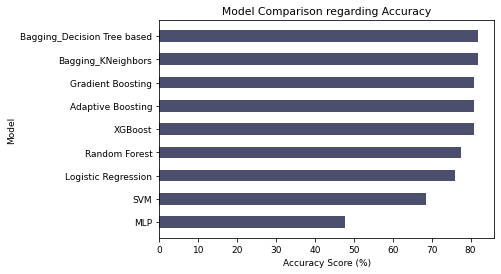

In [32]:
model = list(i[0] for i in mscore)
score = list(round(i[1]*100,2) for i in mscore)

print('Accuracy Score: \n')
for m,s in zip(model, score):
    print(f'{m}: {s}%')

# creating horizontal bar
plt.barh(model, score, height = 0.5, color='#4B4E6D')

plt.xlabel("Accuracy Score (%)")
plt.ylabel("Model")
plt.title("Model Comparison regarding Accuracy")
plt.gca().invert_yaxis()
plt.rc('font', size=9)
plt.show()

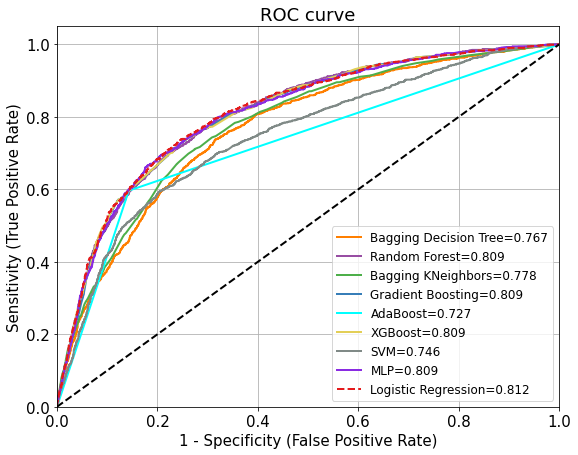

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 7))
matplotlib.rcParams.update({'font.size': 15})
plt.grid()

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

## ROC curve
### Bagging Decision Tree
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, bdt_prediction_proba)
plt.plot(fpr, tpr, color='#ff7f00', lw=2,
         label='Bagging Decision Tree={0:.3f}'.format(roc_auc))
### Random Forest
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, rf_prediction_proba)
plt.plot(fpr, tpr, color='#984ea3', lw=2,
         label='Random Forest={0:.3f}'.format(roc_auc))
### Bagging KNeighbors
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, kn_prediction_proba)
plt.plot(fpr, tpr, color='#4daf4a', lw=2,
         label='Bagging KNeighbors={0:.3f}'.format(roc_auc))
### Gradient Boosting
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, gbc_prediction_proba)
plt.plot(fpr, tpr, color='#377eb8', lw=2,
         label='Gradient Boosting={0:.3f}'.format(roc_auc))
### AdaBoost
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, ada_prediction_proba)
plt.plot(fpr, tpr, color='#00FFFF', lw=2,
         label='AdaBoost={0:.3f}'.format(roc_auc))
### XGBoost
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, xgb_prediction_proba)
plt.plot(fpr, tpr, color='#E3CF57', lw=2,
         label='XGBoost={0:.3f}'.format(roc_auc))
### SVM
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, svm_prediction_proba)
plt.plot(fpr, tpr, color='#808A87', lw=2,
         label='SVM={0:.3f}'.format(roc_auc))
### MLP
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, mlp_prediction_proba)
plt.plot(fpr, tpr, color='#8A2BE2', lw=2,
         label='MLP={0:.3f}'.format(roc_auc))
### Logistic Regression
fpr, tpr, roc_auc = roc_curve_and_score(Y_test, clf_prediction_proba)
plt.plot(fpr, tpr, color='#e41a1c', lw=2, linestyle='--',
         label='Logistic Regression={0:.3f}'.format(roc_auc))

## reference line (diagonal)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

## add legends, labels, and plot the ROC curves
plt.legend(loc="lower right", fontsize="12")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title("ROC curve")
plt.rc('font', size=9)
plt.show()